In [1]:
#### ----------------------------------------------------------------
#### author: dhrubas2, date: Jul 15, 2025
#### generate figures for manuscript 
#### ----------------------------------------------------------------

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix
from scipy.stats import spearmanr, mannwhitneyu
from itertools import product
from functools import reduce
from operator import mul
from math import ceil
from time import time
from plot_functions import (
    make_catplot, make_barplot3, make_roc_plot, make_lollipop_plot, 
    make_heatmap, make_scatterplot, make_dotplot)
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import concordance_index
from copy import copy
from warnings import filterwarnings

_wpath_ = "/data/Ruppin_AI/BRCA_PIF/analysis/dhrubas2/"
os.chdir(_wpath_)


In [2]:
#%% read data for fig 1.

data_paths = ["../../DataForFigure_V2/HoverNet_NPIFs/All_Non_Zero_NPIFs/", 
              "../../DataForFigure_V2/CPTAC_HoverNet_NPIFs/All_Non_Zero_NPIFs/", 
              "../../DataForFigure_V2/POST_NAT_HoverNet_NPIFs/All_Non_Zero_NPIFs/"]
data_files = ["combined_class_predictions_all_subtypes_binary.csv", 
              "External_CPTAC_BRCA_Predictions_All_HoverNet_NPIFs_Filtered_Tiles_Top25Q_Subtypes.csv", 
              "External_POST_NAT_BRCA_Predictions_All_HoverNet_NPIFs_All_Subtypes.csv"]

prob_data_tcga  = pd.read_table(
    data_paths[0] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_cptac = pd.read_table(
    data_paths[1] + data_files[1], sep = ",", header = 0, index_col = 0)
prob_data_pnat  = pd.read_table(
    data_paths[2] + data_files[2], sep = ",", header = 0, index_col = 0)

prob_data_tcga.shape, prob_data_cptac.shape, prob_data_pnat.shape


((556, 14), (89, 14), (49, 14))

In [3]:
#%% prepare data for fig 1.

def get_subtype_dist(data, ncls = 3, aggfunc = "mean", 
                     percent = False):
    if ncls == 3:
        col_map = {"true_label_HER2_Positive" : "HER2+", 
                   "true_label_HR_Positive"   : "HR+", 
                   "true_label_TNBC_3"        : "TNBC"}
    elif ncls == 4:
        col_map = {"true_label_TPBC"   : "TPBC", 
                   "true_label_HER2+"  : "HER2+", 
                   "true_label_HR+"    : "HR+", 
                   "true_label_TNBC_4" : "TNBC"}

    dist = data[
        list(col_map.keys())].rename(
        columns = col_map).apply(
        aggfunc, axis = 0).pipe(
        lambda x: x * 100 if (percent and aggfunc == "mean") else x).convert_dtypes(
        infer_objects = True)

    return dist


fig_data1C  = pd.DataFrame({
    f"{lbl}\n(n = {len(probs):,})": get_subtype_dist(probs, ncls = 3, percent = True)     
    for lbl, probs in zip(["TCGA-BRCA", "CPTAC-BRCA", "POST-NAT-BRCA"], 
                          [prob_data_tcga, prob_data_cptac, prob_data_pnat])}).T

fig_annot1C = pd.DataFrame({
    lbl: dat.map(lambda x: f"{x:0.1f}% ({x * int(lbl.split('= ')[1][:-1]) / 100:0.0f})") 
    for lbl, dat in fig_data1C.iterrows()}).T

fig_data1C.round(4)
fig_annot1C.round(4)


,HER2+,HR+,TNBC
TCGA-BRCA\n(n = 556),14.9% (83),66.5% (370),18.5% (103)
CPTAC-BRCA\n(n = 89),13.5% (12),68.5% (61),18.0% (16)
POST-NAT-BRCA\n(n = 49),20.4% (10),55.1% (27),24.5% (12)


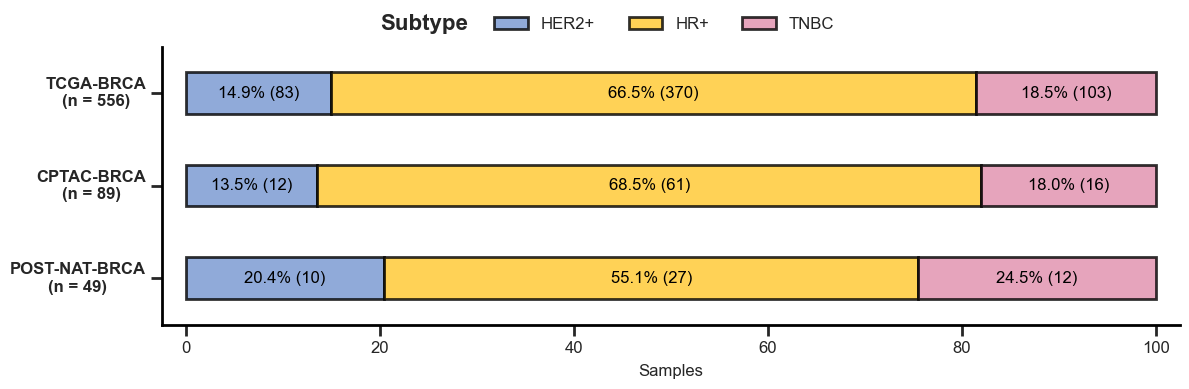

In [4]:
#%% make fig 1 - v3.

sns.set_style("ticks")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors      = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
               "#FFC72C", "#A9A9A9", "#DFDFDF", "#000000"]

fontdict    = {"label": {"size": 12, "weight": "regular"}, 
               "sbttl": {"size": 14, "weight": "bold"}, 
               "title": {"size": 16, "weight": "bold"}, 
               "super": {"size": 20, "weight": "bold"}, 
               "panel": {"size": 36, "weight": "bold"}}

fig_colors1 = [colors[1], colors[5], colors[0]]

## make distribution plot.
fig1_II, ax1_II = plt.subplots(figsize = (12, 4), nrows = 1, ncols = 1)
ax1_II = make_catplot(data = fig_data1C, annots = fig_annot1C, annot_fmt = "%s", height = 0.45, 
                      colors = fig_colors1, ax = ax1_II)
ax1_II.set_xlabel("Samples", labelpad = 6, **fontdict["label"]);
ax1_II.axis([-2.5, 102.5, 2.5, -0.5]);
ax1_II.get_legend().set(bbox_to_anchor = (0.32, 1.03));
ax1_II.text(x = 20, y = -0.68, s = "Subtype", **fontdict["title"]);

fig1_II.tight_layout()
plt.show()


In [5]:
#%% save fig 1.

svdat = False
if svdat: 
    out_path  = "../../plots/v3/"
    out_file  = "All_dataset_summary.pdf"
    out_data  = copy(fig1_II)
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    
    print("saving dataset summary plot...");    _dt = time()
    os.makedirs(out_path, exist_ok = True)                            # creates dir if doesn't exist already
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file)
    _dt = time() - _dt;    print(f"done! elapsed time = {ceil(_dt)} sec.")


In [6]:
#%% read data for fig 2.

data_paths = ["../../DataForFigure_V2/HIFs/All_Non_Zero_HIFs/", 
              "../../DataForFigure_V2/nuHIFs/All_Non_Zero_nuHIFs/", 
              "../../DataForFigure_V2/PIFs/All_Non_Zero_PIFs/", 
              "../../DataForFigure_V2/PathAI_NPIFs/All_Non_Zero_PathAI_NPIFs/", 
              "../../DataForFigure_V2/Direct_Features/All_Non_Zero_Direct_Features/"]

data_files = ["combined_class_predictions_all_subtypes_binary.csv"]

prob_data_hif    = pd.read_table(
    data_paths[0] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_nuhif  = pd.read_table(
    data_paths[1] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_pif    = pd.read_table(
    data_paths[2] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_npif   = pd.read_table(
    data_paths[3] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_direct = pd.read_table(
    data_paths[4] + data_files[0], sep = ",", header = 0, index_col = 0)

patients_cmn     = reduce(np.intersect1d, [prob_data_hif.index, prob_data_nuhif.index, 
                                           prob_data_pif.index, prob_data_npif.index, 
                                           prob_data_direct.index])
prob_data_hif    = prob_data_hif.loc[patients_cmn]
prob_data_nuhif  = prob_data_nuhif.loc[patients_cmn]
prob_data_pif    = prob_data_pif.loc[patients_cmn]
prob_data_npif   = prob_data_npif.loc[patients_cmn]
prob_data_direct = prob_data_direct.loc[patients_cmn]

(prob_data_hif.shape, prob_data_nuhif.shape, prob_data_pif.shape, 
 prob_data_npif.shape, prob_data_direct.shape)


((556, 14), (556, 14), (556, 14), (556, 14), (556, 14))

In [7]:
assert sorted(prob_data_hif.columns) == reduce(
    np.intersect1d, [prob_data_hif.columns, prob_data_nuhif.columns, 
                     prob_data_pif.columns, prob_data_npif.columns, 
                     prob_data_direct.columns]).tolist()

prob_data_hif.columns


Index(['true_label_HER2_Positive', 'predicted_probability_HER2_Positive',
       'true_label_HR_Positive', 'predicted_probability_HR_Positive',
       'true_label_TNBC_3', 'predicted_probability_TNBC_3', 'true_label_HR+',
       'predicted_probability_HR+', 'true_label_TNBC_4',
       'predicted_probability_TNBC_4', 'true_label_TPBC',
       'predicted_probability_TPBC', 'true_label_HER2+',
       'predicted_probability_HER2+'],
      dtype='object')

In [8]:
#%% prepare data for fig 2.

subtypes  = ["HER2_Positive", "HR_Positive", "TNBC_3"]
# subtypes  = ["TPBC", "HER2+", "HR+", "TNBC_4"]

data_all  = {"HIFs"  : prob_data_hif, "nuHIFs": prob_data_nuhif, 
             "PIFs"  : prob_data_pif, "NPIFs" : prob_data_npif, 
             "Direct": prob_data_direct}

## compute scores.
aucs_sbtyp  = pd.DataFrame({
    lbl: {sb: roc_auc_score(dat[f"true_label_{sb}"], 
                            dat[f"predicted_probability_{sb}"]) 
          for sb in subtypes} for lbl, dat in data_all.items() })


## prepare fig data.
ds_info = pd.DataFrame([
    {"subtype": sb, "n": prob_data_pif[f"true_label_{sb}"].sum().astype(int)} 
    for sb in subtypes])
ds_info["label"] = ds_info.apply(
    lambda x: f"{x.subtype.replace('_Positive', '+').split('_')[0]} (n = {x.n})", 
    axis = 1)

mdl_ord    = {"NPIFs" : "NPIFs (m = 12)", 
              "PIFs"  : "PIFs (m = 25)", 
              "HIFs"  : "HIFs (m = 607)", 
              "nuHIFs": "nuHIFs (m = 90)", 
              "Direct": "Direct (m = 512)"}

fig_data2B = aucs_sbtyp[
    list(mdl_ord.keys())].set_axis(
    labels = ds_info.label, axis = 0).T.rename(
    index = mdl_ord).reset_index(
    names = "feature").melt(
    id_vars = ["feature"], var_name = "subtype", value_name = "score")

print(ds_info, end = "\n\n")
fig_data2B.round(4)


         subtype    n           label
0  HER2_Positive   83  HER2+ (n = 83)
1    HR_Positive  370   HR+ (n = 370)
2         TNBC_3  103  TNBC (n = 103)



,feature,subtype,score
0,NPIFs (m = 12),HER2+ (n = 83),0.7256
1,PIFs (m = 25),HER2+ (n = 83),0.6972
2,HIFs (m = 607),HER2+ (n = 83),0.7028
3,nuHIFs (m = 90),HER2+ (n = 83),0.6936
4,Direct (m = 512),HER2+ (n = 83),0.6997
5,NPIFs (m = 12),HR+ (n = 370),0.8035
6,PIFs (m = 25),HR+ (n = 370),0.8107
7,HIFs (m = 607),HR+ (n = 370),0.8278
8,nuHIFs (m = 90),HR+ (n = 370),0.7729
9,Direct (m = 512),HR+ (n = 370),0.7684


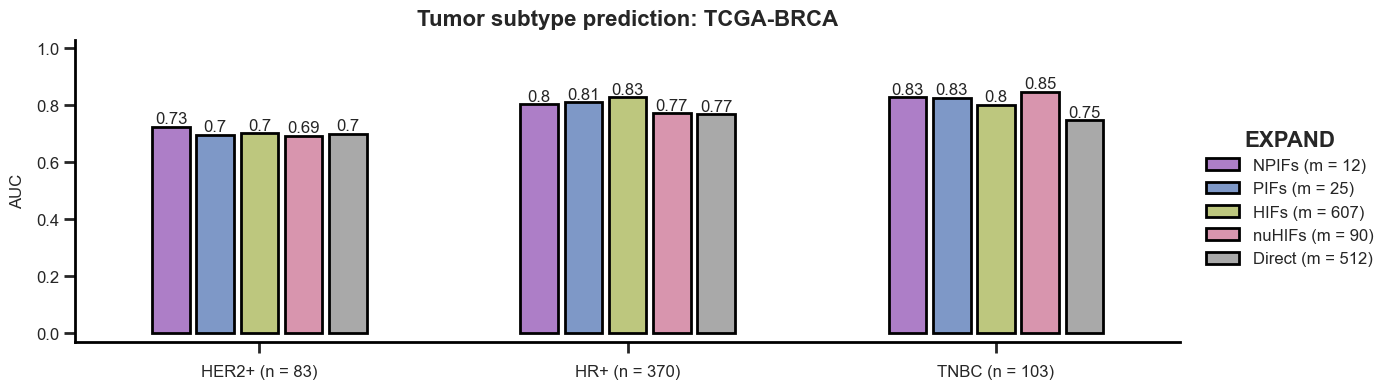

In [9]:
#%% make fig 2 - v2.

sns.set_style("ticks")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors       = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
                "#FFC72C", "#708090", "#A9A9A9", "#000000"]

panel_fonts  = {"weight": "bold", "size": 36, "color": "#000000"}
label_fonts  = {"weight": "regular", "size": 14, "color": "#000000"}
legend_fonts = {"item" : {"size": 12, "weight": "regular"}, 
                "title": {"size": 16, "weight": "bold"}}

fig_colors2  = [colors[k] for k in [3, 1, 4, 0, 7]]
fig_title2   = "Tumor subtype prediction: TCGA-BRCA"

## make barplots.
fig2_II, ax2_II = plt.subplots(figsize = (14, 4), nrows = 1, ncols = 1)
ax2_II = make_barplot3(data = fig_data2B, x = "subtype", y = "score", 
                       hue = "feature", width = 0.6, gap = 0.15, bar_labels = True, 
                       colors = fig_colors2, title = fig_title2, legend = True, 
                       legend_title = "EXPAND", ax = ax2_II)
ax2_II.set_ylabel("AUC", labelpad = 8, **legend_fonts["item"]);
ax2_II.axis([-0.5, len(subtypes) - 0.5, -0.03, 1.03]);
ax2_II.get_legend().set(bbox_to_anchor = (1.01, 0.20), frame_on = False);

fig2_II.tight_layout()
plt.show()


In [10]:
#%% save fig 2.

svdat = False
if svdat: 
    out_path  = "../../plots/v3/"
    out_file  = "TCGA_subtype_prediction_all_feature_types_v3.pdf"
    out_data  = copy(fig2_II)
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    
    print("saving performance plots for all features...");    _dt = time()
    os.makedirs(out_path, exist_ok = True)                            # creates dir if doesn't exist already
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file)
    _dt = time() - _dt;    print(f"done! elapsed time = {ceil(_dt)} sec.")


In [11]:
#%% read data for fig 3.

data_paths = ["../../DataForFigure_V2/HoverNet_NPIFs/All_Non_Zero_NPIFs/", 
              "../../DataForFigure_V2/PathAI_NPIFs/All_Non_Zero_PathAI_NPIFs/"]
data_files = ["confusion_matrix_combined_others.csv", 
              "Original_NPIFs2_withSubtypes2.csv", 
              "Original_PathAI_NPIFs.csv"]

conf_mat_data = pd.read_table(data_paths[0] + data_files[0], sep = ",", 
                              header = 0, index_col = 0)
npifs2_data   = pd.read_table(data_paths[0] + data_files[1], sep = ",", 
                              header = 0, index_col = 0)
npifs_data    = pd.read_table(data_paths[1] + data_files[2], sep = ",", 
                              header = 0, index_col = 0)
npifs_data.sort_index(ascending = False, inplace = True)
npifs2_data.sort_index(ascending = False, inplace = True)

assert (npifs_data.index.tolist() == npifs2_data.index.tolist() and 
        set(npifs_data.columns) <= set(npifs2_data.columns))

conf_mat_data.shape, npifs_data.shape, npifs2_data.shape


((4, 4), (556, 12), (556, 22))

In [12]:
#%% prepare data for fig 3.

cell_types = {"Neoplastic"   : "Cancer", 
              "Inflammatory" : "Immune", 
              "Connective"   : "Fibroblast", 
              "Others"       : "Others"}

## confusion matrix (true x pred).
fig_data3B = conf_mat_data.rename(
    index = cell_types, columns = cell_types)


## compute cell-type-specific metrics (macro-average).
fig_data3C = { }
for ctp in cell_types.values():
    tp = fig_data3B.loc[ctp, ctp]
    fp = fig_data3B.loc[:, ctp].sum() - tp
    fn = fig_data3B.loc[ctp, :].sum() - tp
    tn = fig_data3B.values.sum() - (tp + fp + fn)
    
    fig_data3C[ctp] = {
        "Accuracy"    : (tp + tn) / (tp + fp + fn + tn), 
        "Sensitivity" : tp / (tp + fn), 
        "Precision"   : tp / (tp + fp), 
        "F1-score"    : 2 * tp / (2 * tp + fp + fn)}

fig_data3C = pd.DataFrame(
    fig_data3C).reset_index(
    names = "metric").melt(
    id_vars = "metric", var_name = "cell_type", value_name = "score")

print(fig_data3B, end = "\n\n")
print(f"global accuracy = {np.diag(fig_data3B).sum() / fig_data3B.values.sum():0.4}")
fig_data3C.round(4)


            Cancer  Immune  Fibroblast  Others
Cancer        5935     110         153     133
Immune        1155    5709         543     192
Fibroblast     604     274        1068      49
Others         647     494         310     115

global accuracy = 0.7333


,metric,cell_type,score
0,Accuracy,Cancer,0.8398
1,Sensitivity,Cancer,0.9375
2,Precision,Cancer,0.7115
3,F1-score,Cancer,0.8090
4,Accuracy,Immune,0.8417
5,Sensitivity,Immune,0.7513
6,Precision,Immune,0.8667
7,F1-score,Immune,0.8049
8,Accuracy,Fibroblast,0.8895
9,Sensitivity,Fibroblast,0.5353


In [13]:
#%% prepare data for fig 3 - cont'd.

npifs_core = ["Major Axis", "Minor Axis", "Perimeter", "Area", 
              "Eccentricity", "Circularity"]

## correlation between selected vs. extracted NPIFs. 
fig_data3D, fig_stat3D = { }, { }
for npif in npifs_core:
    mdata = (npifs_data[f"Mean {npif}"], npifs2_data[f"Mean {npif}"])
    sdata = (npifs_data[f"Std {npif}"], npifs2_data[f"Std {npif}"])
    fig_data3D[f"Mean {npif}"] = pd.concat(
        mdata, axis = 1, keys = ["selected", "extracted"])
    fig_data3D[f"SD {npif}"]   = pd.concat(
        sdata, axis = 1, keys = ["selected", "extracted"])
    fig_stat3D[f"Mean {npif}"] = spearmanr(*mdata)
    fig_stat3D[f"SD {npif}"]   = spearmanr(*sdata)

fig_data3D = pd.concat(
    fig_data3D, axis = 1).apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis = 0)

fig_stat3D = pd.DataFrame(
    fig_stat3D, index = ["rho", "pval"]).T.sort_values(
    by = ["pval", "rho"], ascending = [True, False])
fig_stat3D["label"] = [
    rf"{npif.split(' ')[0]} ($\rho$ = {stat.rho:0.3})" 
    for npif, stat in fig_stat3D.iterrows()]

print(fig_stat3D.round(4), end = "\n\n")
fig_data3D.round(4).iloc[:6, :10]


                      rho  pval                  label
SD Major Axis      0.9188   0.0    SD ($\rho$ = 0.919)
SD Area            0.9156   0.0    SD ($\rho$ = 0.916)
SD Minor Axis      0.9141   0.0    SD ($\rho$ = 0.914)
SD Perimeter       0.9130   0.0    SD ($\rho$ = 0.913)
Mean Eccentricity  0.8643   0.0  Mean ($\rho$ = 0.864)
Mean Major Axis    0.8566   0.0  Mean ($\rho$ = 0.857)
SD Eccentricity    0.8430   0.0    SD ($\rho$ = 0.843)
Mean Area          0.8397   0.0   Mean ($\rho$ = 0.84)
Mean Perimeter     0.8343   0.0  Mean ($\rho$ = 0.834)
Mean Minor Axis    0.7849   0.0  Mean ($\rho$ = 0.785)
Mean Circularity   0.7241   0.0  Mean ($\rho$ = 0.724)
SD Circularity     0.4719   0.0    SD ($\rho$ = 0.472)



Mean Major Axis           SD Major Axis            \
                    selected extracted      selected extracted   
sample_id                                                        
TCGA-EW-A1PG          0.3158    0.3424        0.2504    0.2808   
TCGA-EW-A1PF          0.4858    0.5191        0.3344    0.4627   
TCGA-EW-A1PE          0.5770    0.5522        0.3432    0.3627   
TCGA-EW-A1PD          0.3878    0.5393        0.4395    0.5645   
TCGA-EW-A1PB          0.3562    0.4276        0.3388    0.3832   
TCGA-EW-A1PA          0.1852    0.1840        0.2015    0.2392   

             Mean Minor Axis           SD Minor Axis           Mean Perimeter  \
                    selected extracted      selected extracted       selected   
sample_id                                                                       
TCGA-EW-A1PG          0.3794    0.3049        0.2402    0.2841         0.3028   
TCGA-EW-A1PF          0.6153    0.4413        0.3406    0.4564         0.5024   
TCGA-EW-A1PE          0.7173    0.5767        0.3770    0.4560         0.5815   
TCGA-EW-A1PD          0.4496    0.4099        0.4009    0.4896         0.4050   
TCGA-EW-A1PB          0.4652    0.4469        0.4477    0.4791         0.3650   
TCGA-EW-A1PA          0.1640    0.1064        0.1770    0.1978         0.1511   

                        
             extracted  
sample_id               
TCGA-EW-A1PG    0.3158  
TCGA-EW-A1PF    0.4996  
TCGA-EW-A1PE    0.5420  
TCGA-EW-A1PD    0.5455  
TCGA-EW-A1PB    0.4299  
TCGA-EW-A1PA    0.1457

In [14]:
#%% prepare data for fig 3 - cont'd.

subtypes = ["HER2_Positive", "HR_Positive", "TNBC_3"]
# subtypes = ["TPBC", "HER2+", "HR+", "TNBC_4"]

sb_sizes = npifs2_data[subtypes].sum().reset_index().set_axis(
    labels = ["subtype", "n"], axis = 1)
sb_sizes["label"] = sb_sizes.apply(
    lambda x: f"{x.subtype.replace('_Positive', '+').split('_')[0]} (n = {x.n:,})", 
    axis = 1)

## compute association between subtypes & NPIFs (wilcoxon rank-sum test). 
## effect size: rank-biserial correlation, r = 2 * U1 / (n1 * n2)
fig_data3E = { }
for sb in subtypes:
    fig_data3E[sb] = { }
    for npif in map(
        lambda x: " ".join(x), product(["Mean", "Std"], npifs_core)):
        pdata = npifs2_data.groupby(
            by = sb, sort = True).apply(
            lambda df: df[npif].tolist(), include_groups = False).pipe(
            tuple)[::-1]    
        u1, pval  = mannwhitneyu(*pdata, alternative = "two-sided")
        rho, pval = 2 * u1 / mul(*map(len, pdata)) - 1, (
            "****" if pval <= 0.0001 else "*** " if pval <= 0.001 else 
            "**  " if pval <= 0.01 else "*   " if pval <= 0.05 else "")
        
        fig_data3E[sb][npif.replace("Std", "SD")] = (rho, pval)
    
    fig_data3E[sb] = pd.DataFrame(fig_data3E[sb], index = ["rho", "pval"])

fig_data3E = pd.concat(fig_data3E, axis = 0).T.rename(
    columns = dict(zip(sb_sizes["subtype"], sb_sizes["label"])), 
    level = 0).convert_dtypes()
fig_data3E["mean_abs_rho"] = fig_data3E.loc[
    :, (slice(None), "rho")].abs().mean(
    axis = 1)
fig_data3E.sort_values(
    by = "mean_abs_rho", ascending = False, inplace = True)

fig_data3E.round(4)


HER2+ (n = 83)       HR+ (n = 370)       TNBC (n = 103)  \
                             rho  pval           rho  pval            rho   
SD Minor Axis             0.3522  ****       -0.4487  ****         0.3654   
SD Area                   0.3135  ****       -0.4309  ****         0.3717   
SD Perimeter               0.261  ***        -0.4299  ****         0.4145   
SD Major Axis             0.2592  ***        -0.4255  ****         0.4095   
Mean Major Axis           0.2715  ****       -0.2667  ****          0.165   
Mean Area                 0.2679  ****       -0.2611  ****         0.1596   
Mean Perimeter            0.2507  ***        -0.2496  ****         0.1572   
Mean Eccentricity         0.1999  **         -0.2472  ****         0.1964   
Mean Circularity         -0.1223              0.2116  ****        -0.2092   
SD Circularity            0.1423  *          -0.2012  ***          0.1771   
Mean Minor Axis             0.21  **         -0.1766  ***          0.0838   
SD Eccentricity           0.0811             -0.0637               0.0257   

                        mean_abs_rho  
                   pval               
SD Minor Axis      ****       0.3888  
SD Area            ****       0.3721  
SD Perimeter       ****       0.3685  
SD Major Axis      ****       0.3647  
Mean Major Axis    **         0.2344  
Mean Area          *          0.2295  
Mean Perimeter     *          0.2192  
Mean Eccentricity  **         0.2145  
Mean Circularity   ***         0.181  
SD Circularity     **         0.1736  
Mean Minor Axis               0.1568  
SD Eccentricity               0.0569

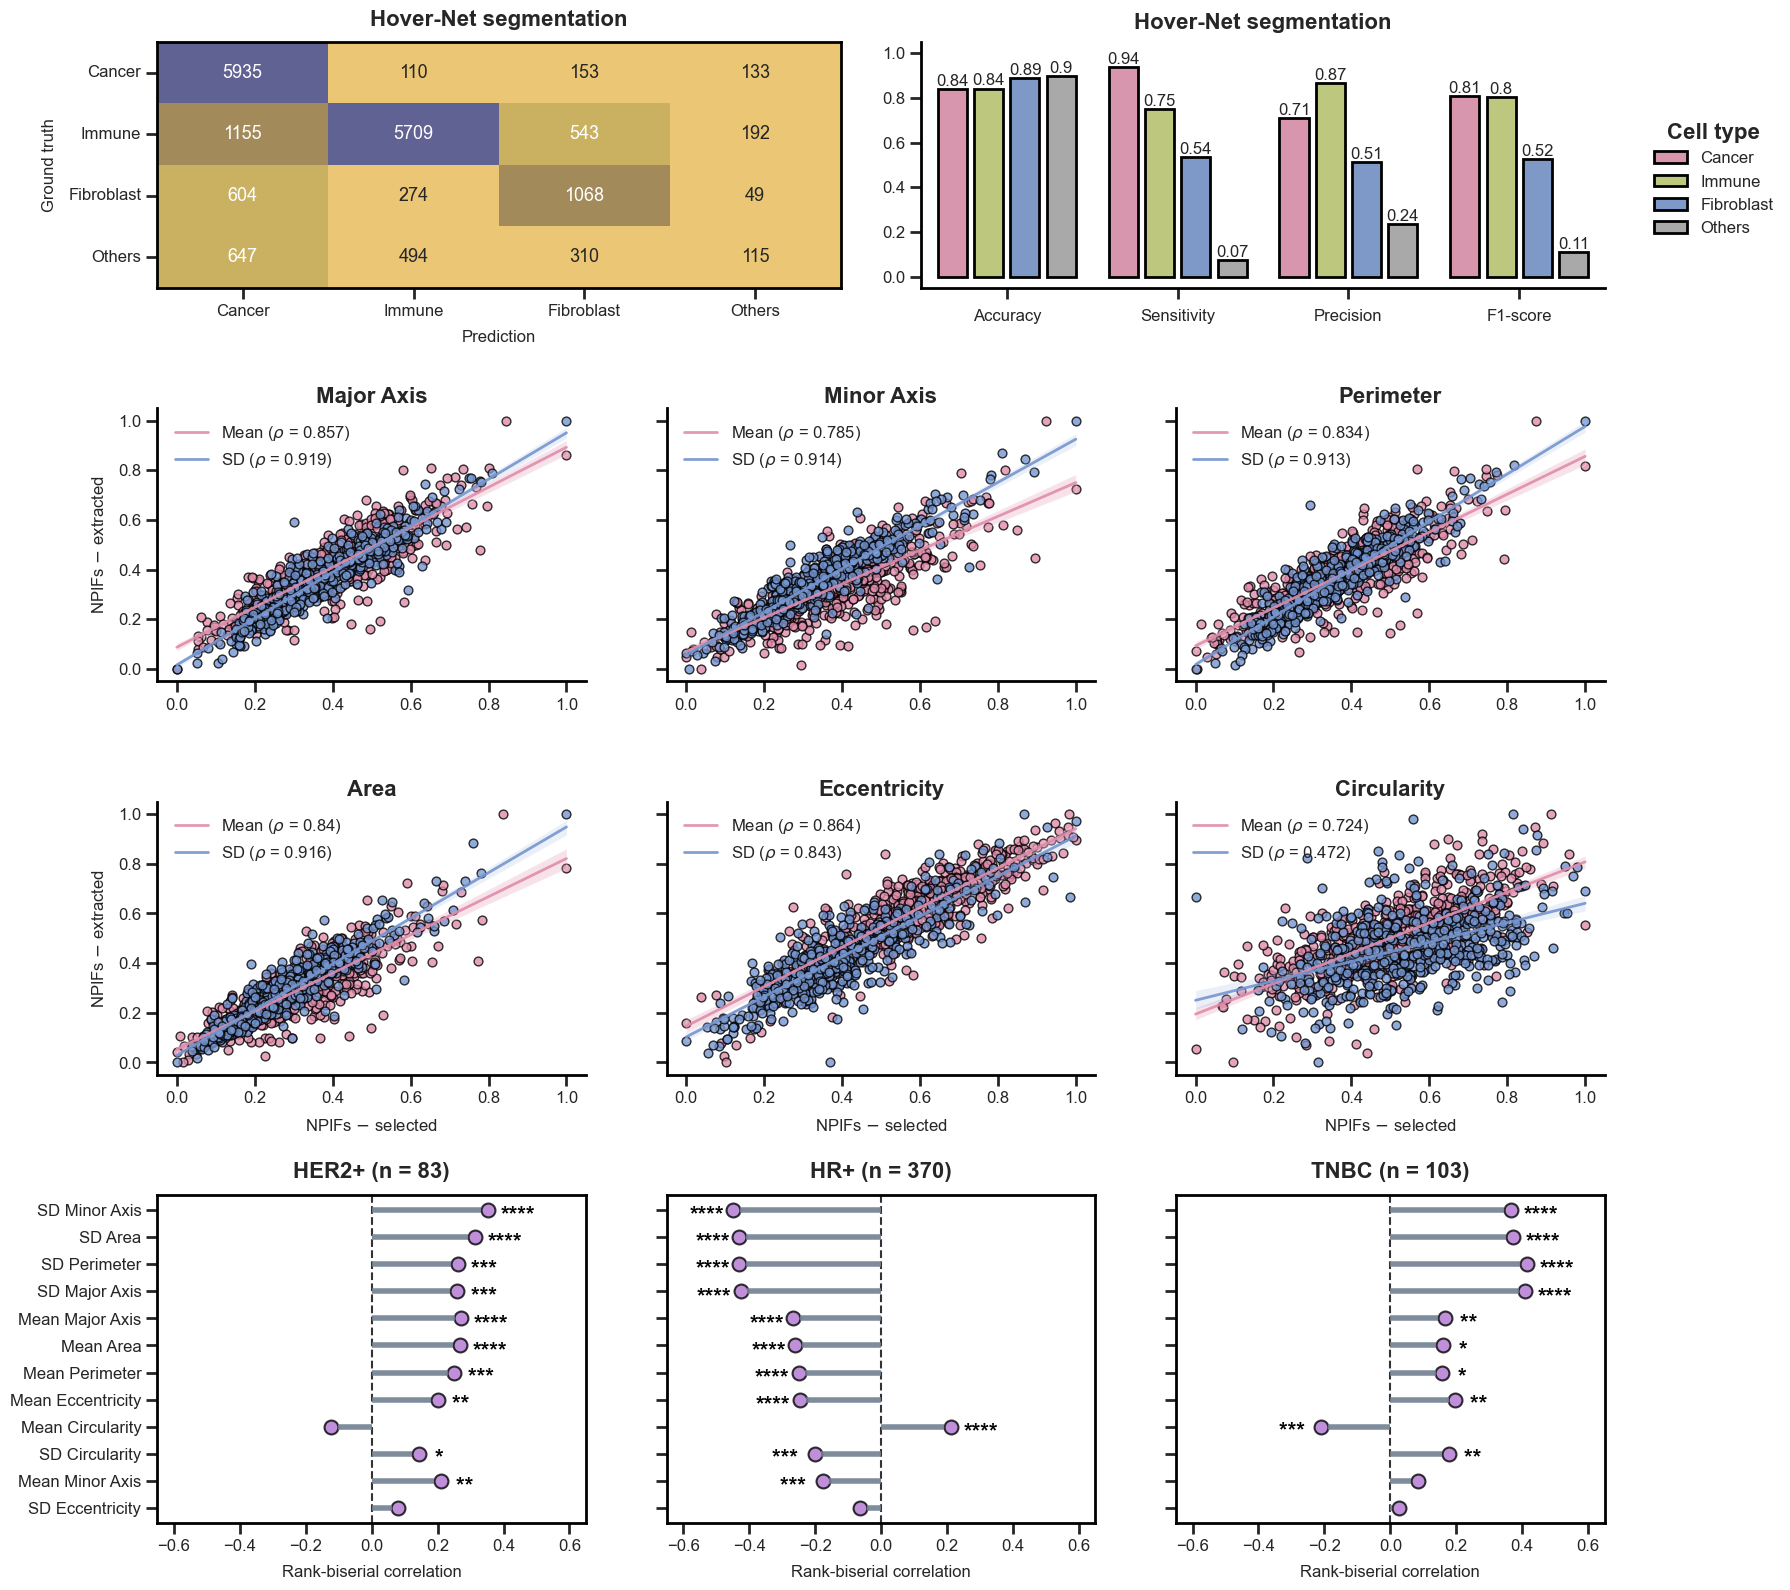

In [15]:
#%% make fig 3.

filterwarnings(action = "ignore")

sns.set_style("ticks")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors       = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
                "#FFC72C", "#708090", "#A9A9A9", "#000000"]

panel_fonts  = {"weight": "bold", "size": 36, "color": "#000000"}
label_fonts  = {"weight": "regular", "size": 14, "color": "#000000"}
legend_fonts = {"item" : {"size": 12, "weight": "regular"}, 
                "title": {"size": 16, "weight": "bold"}}

ann_props    = {"color": colors[-1], "family": "sans", "size": 16, "weight": "bold", 
                "alpha": 0.99, "ha": "center", "va": "center", "ma": "center", 
                "rotation": None, "wrap": True}

## make composite figure.
fig3_II, ax3_II = plt.subplot_mosaic(
    mosaic = [["B", "B", "B", "C", "C", "C"], ["D1", "D1", "D2", "D2", "D3", "D3"], 
              ["D4", "D4", "D5", "D5", "D6", "D6"], ["E1", "E1", "E2", "E2", "E3", "E3"]], 
    figsize = (18, 16), height_ratios = [0.9, 1, 1, 1.2])

## HoverNet performance.
fig_title3  = "Hover-Net segmentation"
fig_colors3 = [colors[0], colors[4], colors[1], colors[7]]

ax3_II["B"] = make_heatmap(data = fig_data3B, square = False, center = 500, cmap = "tab20b_r", 
                           bold = False, cbar = False, labels = ["Prediction", "Ground truth"], 
                           title = fig_title3, ax = ax3_II["B"])

ax3_II["C"] = make_barplot3(data = fig_data3C, x = "metric", y = "score", hue = "cell_type", 
                            width = 0.85, gap = 0.2, colors = fig_colors3, bar_labels = True, 
                            title = fig_title3, legend_title = "Cell type", ax = ax3_II["C"])
ax3_II["C"].set_ylim([-0.05, 1.05]);
ax3_II["C"].get_legend().set(bbox_to_anchor = (1.05, 0.15), frame_on = False);

## NPIFs - NPIFs2 correlation.
fig_labels3 = ["NPIFs $-$ selected", "NPIFs $-$ extracted"]
fig_colors3 = [colors[0], colors[1]]
for k, npif in enumerate(npifs_core, start = 1):
    ax = ax3_II[f"D{k}"]
    ax = make_scatterplot(data = fig_data3D[f"Mean {npif}"], x = "selected", y = "extracted", 
                          fit = True, size = 40, color = fig_colors3[0], title = npif, 
                          labels = fig_labels3, ax = ax)
    ax = make_scatterplot(data = fig_data3D[f"SD {npif}"], x = "selected", y = "extracted", 
                          fit = True, size = 40, color = fig_colors3[1], title = npif, 
                          labels = fig_labels3, ax = ax)
    
    if k < 4:    ax.set_xlabel(None)
    if k != 1 and k != 4:
        ax.set_ylabel(None)
        ax.set_yticklabels([""] * len(ax.get_yticklabels()));
    ax.legend(labels = ["_", fig_stat3D.loc[f"Mean {npif}", "label"], "_", "_", 
                        fig_stat3D.loc[f"SD {npif}", "label"], "_"], 
              loc = (0.025, 0.75), prop = legend_fonts["item"])

## NPIFs2 - subtype association.
fig_colors3 = [colors[3], colors[6], colors[-1]]
for k, sb in enumerate(sb_sizes["label"], start = 1):
    ax, dat = ax3_II[f"E{k}"], fig_data3E[sb].reset_index(names = "feature")
    ax = make_lollipop_plot(data = dat, x = "rho", y = "feature", width = 4, size = 100, 
                            offset = 0.02, colors = fig_colors3, title = sb, 
                            xlabel = "Rank-biserial correlation", ax = ax)
    [ax.annotate(xy   = (dat.rho + (0.09 if dat.rho > 0 else -0.08), y + 0.2), 
                 text = dat.pval, **ann_props) for y, dat in dat.iterrows()];
    if k > 1:    ax.set_yticklabels([""] * len(ax.get_yticklabels()))
    ax.set_xlim([-0.65, 0.65]);

fig3_II.tight_layout(h_pad = 2, w_pad = 3)
plt.show()


In [16]:
#%% save fig 3.

svdat = False
if svdat: 
    out_path  = "../../plots/v3/"
    out_file  = "TCGA_HoverNet_segmentation_NPIFs_vs_NPIFs2.pdf"
    out_data  = copy(fig3_II)
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    
    print("saving Hover-Net performance plots...");    _dt = time()
    os.makedirs(out_path, exist_ok = True)                            # creates dir if doesn't exist already
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file)
    _dt = time() - _dt;    print(f"done! elapsed time = {ceil(_dt)} sec.")


In [17]:
#%% read data for fig 5. 

data_paths = ["../../DataForFigure_V2/PathAI_NPIFs/All_Non_Zero_PathAI_NPIFs/", 
              "../../DataForFigure_V2/HoverNet_NPIFs/All_Non_Zero_NPIFs/", 
              "../../DataForFigure_V2/CPTAC_HoverNet_NPIFs/All_Non_Zero_NPIFs/", 
              "../../DataForFigure_V2/POST_NAT_HoverNet_NPIFs/All_Non_Zero_NPIFs/"]
data_files = ["combined_class_predictions_all_subtypes_binary.csv", 
              "External_CPTAC_BRCA_Predictions_All_HoverNet_NPIFs_Filtered_Tiles_Top25Q_Subtypes.csv", 
              "External_POST_NAT_BRCA_Predictions_All_HoverNet_NPIFs_All_Subtypes.csv", 
              "HER2_Positive_foldwise_coefficients.csv", 
              "HR_Positive_foldwise_coefficients.csv", 
              "TNBC_3_foldwise_coefficients.csv"]

prob_data_tcga0 = pd.read_table(
    data_paths[0] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_tcga  = pd.read_table(
    data_paths[1] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_cptac = pd.read_table(
    data_paths[2] + data_files[1], sep = ",", header = 0, index_col = 0)
prob_data_pnat  = pd.read_table(
    data_paths[3] + data_files[2], sep = ",", header = 0, index_col = 0)

feat_coefs_tcga = pd.concat({
    file.split("_fold")[0]: pd.read_table(
        data_paths[1] + file, sep = ",", header = 0, index_col = 0).rename(
        columns = lambda x: x.replace("Std", "SD")).T
    for file in data_files[3:]}, axis = 1)

assert ((prob_data_tcga0.pipe(lambda df: df.index.tolist() + df.columns.tolist()) == 
         prob_data_tcga.pipe(lambda df: df.index.tolist() + df.columns.tolist())) and 
        (set(prob_data_tcga.columns) == set(prob_data_cptac.columns)) and 
        (set(prob_data_tcga.columns) == set(prob_data_pnat.columns)))

print((prob_data_tcga0.shape, prob_data_tcga.shape, prob_data_cptac.shape, 
       prob_data_pnat.shape))
feat_coefs_tcga.round(4)


((556, 14), (556, 14), (89, 14), (49, 14))


HER2_Positive                                      \
                         Fold_1   Fold_2   Fold_3   Fold_4   Fold_5   
Mean Area              -27.4663  -6.6940 -27.9494 -32.9662 -24.2810   
Mean Major Axis         34.3350  29.6476   1.9927  27.6915  20.0098   
Mean Minor Axis        -34.8366 -34.8950  -3.3077 -18.9330 -13.3074   
Mean Perimeter          20.4507   7.7355  19.0086   7.6931   8.4074   
Mean Eccentricity       -8.1921 -11.8730   4.2403  -6.4150  -2.6787   
Mean Circularity         4.0395   0.9932   3.9655  -2.7545   3.2655   
SD Area                 15.8643   1.1951  25.7643  38.7252  12.2676   
SD Major Axis           14.0312   9.7693   7.4873   6.3463  23.9285   
SD Minor Axis           25.0934  32.5471  19.8376  17.6769  33.0713   
SD Perimeter           -45.7629 -37.6220 -42.3546 -44.1504 -58.8764   
SD Eccentricity          0.3847  -1.4625   1.0299  -0.8490  -0.5007   
SD Circularity           4.2484   3.7663   5.1381   0.6256   5.9516   

                  HR_Positive                                       TNBC_3  \
                       Fold_1   Fold_2   Fold_3   Fold_4   Fold_5   Fold_1   
Mean Area              9.4347   0.0000 -24.1307  -1.0031  -0.2935  14.5512   
Mean Major Axis      -20.3140 -15.8023 -24.6799 -20.4309 -33.5969   5.3295   
Mean Minor Axis       44.5778  53.4245  60.2796  51.0163  59.4029 -42.1272   
Mean Perimeter       -16.9588 -21.5942  -6.8030 -14.0033 -11.3445  16.1400   
Mean Eccentricity     10.8520   9.9698  15.5540  11.3843  13.9120 -12.1786   
Mean Circularity      -1.4101  -2.5131  -0.5613  -0.6346  -2.0619   0.7412   
SD Area              -46.5293 -33.1466 -28.9939 -39.8840 -34.8549  14.2938   
SD Major Axis         -6.8792  -2.7480   9.2927  -4.3531  -6.9364  -4.9680   
SD Minor Axis        -10.9291 -13.4300 -11.9526  -9.2604 -16.5932   4.7158   
SD Perimeter          39.4903  30.6371  16.5326  32.2995  37.7880   2.5330   
SD Eccentricity        1.5095   1.9099   1.1593   1.7754   1.3843  -2.8427   
SD Circularity        -1.3718  -2.0242  -0.9526  -2.5410  -1.5081  -3.5253   

                                                       
                    Fold_2   Fold_3   Fold_4   Fold_5  
Mean Area          33.7097   3.2150  14.0505  21.9362  
Mean Major Axis    12.4568   0.0000   3.0291  15.3748  
Mean Minor Axis   -64.2563 -11.9494 -42.3312 -54.3442  
Mean Perimeter     14.8643   0.0000  17.2439  12.2264  
Mean Eccentricity -14.4690  -4.3677 -11.3485 -15.2774  
Mean Circularity    1.2232  -0.3336   1.6194  -0.4508  
SD Area           -11.2816  12.6875  -0.0599   8.5079  
SD Major Axis       5.4966   0.8736   2.7884   0.0000  
SD Minor Axis      16.0160   0.0000   8.4783   0.2813  
SD Perimeter        0.0000   0.0000   2.1352   3.5209  
SD Eccentricity    -3.5845  -1.6257  -3.1545  -2.4834  
SD Circularity     -2.1559  -2.5474  -2.1336  -0.9697

In [18]:
#%% prepare data for fig 5.

subtypes   = ["HER2_Positive", "HR_Positive", "TNBC_3"]
# subtypes   = ["TPBC", "HER2+", "HR+", "TNBC_4"]
subtypes   = {sb: sb.replace("_Positive", "+").split("_")[0] for sb in subtypes}

## CV results.
fig_data5A = pd.concat([prob_data_tcga0, prob_data_tcga], axis = 0)
fig_data5A["feature"] = np.repeat(
    ["NPIFs $-$ selected", "NPIFs $-$ extracted"], repeats = len(fig_data5A) / 2)
fig_data5A = pd.concat({
    sb_: fig_data5A[
        [f"true_label_{sb}", f"predicted_probability_{sb}", "feature"]].set_axis(
        labels = ["label", "pred", "feature"], axis = 1) 
    for sb, sb_ in subtypes.items()}, axis = 1)

## validation results.
fig_data5B = pd.concat([prob_data_cptac, prob_data_pnat], axis = 0)
fig_data5B["cohort"] = (["CPTAC-BRCA"] * len(prob_data_cptac) + 
                        ["POST-NAT-BRCA"] * len(prob_data_pnat))
fig_data5B = pd.concat({
    sb_: fig_data5B[
        [f"true_label_{sb}", f"predicted_probability_{sb}", "cohort"]].set_axis(
        labels = ["label", "pred", "cohort"], axis = 1) 
    for sb, sb_ in subtypes.items()}, axis = 1)

## feature importance.
feat_ord   = feat_coefs_tcga.abs().mean(axis = 1).sort_values(ascending = False).index
fig_data5C = pd.concat({
    sb_: feat_coefs_tcga.loc[feat_ord, sb].reset_index(
        names = "feature").melt(
        id_vars = "feature", var_name = "model", value_name = "coef")    
    for sb, sb_ in subtypes.items()}, axis = 1)

fig_data5C.round(4).head(6)


HER2+                               HR+                   \
           feature   model     coef          feature   model     coef   
0  Mean Minor Axis  Fold_1 -34.8366  Mean Minor Axis  Fold_1  44.5778   
1     SD Perimeter  Fold_1 -45.7629     SD Perimeter  Fold_1  39.4903   
2          SD Area  Fold_1  15.8643          SD Area  Fold_1 -46.5293   
3  Mean Major Axis  Fold_1  34.3350  Mean Major Axis  Fold_1 -20.3140   
4        Mean Area  Fold_1 -27.4663        Mean Area  Fold_1   9.4347   
5    SD Minor Axis  Fold_1  25.0934    SD Minor Axis  Fold_1 -10.9291   

              TNBC                   
           feature   model     coef  
0  Mean Minor Axis  Fold_1 -42.1272  
1     SD Perimeter  Fold_1   2.5330  
2          SD Area  Fold_1  14.2938  
3  Mean Major Axis  Fold_1   5.3295  
4        Mean Area  Fold_1  14.5512  
5    SD Minor Axis  Fold_1   4.7158

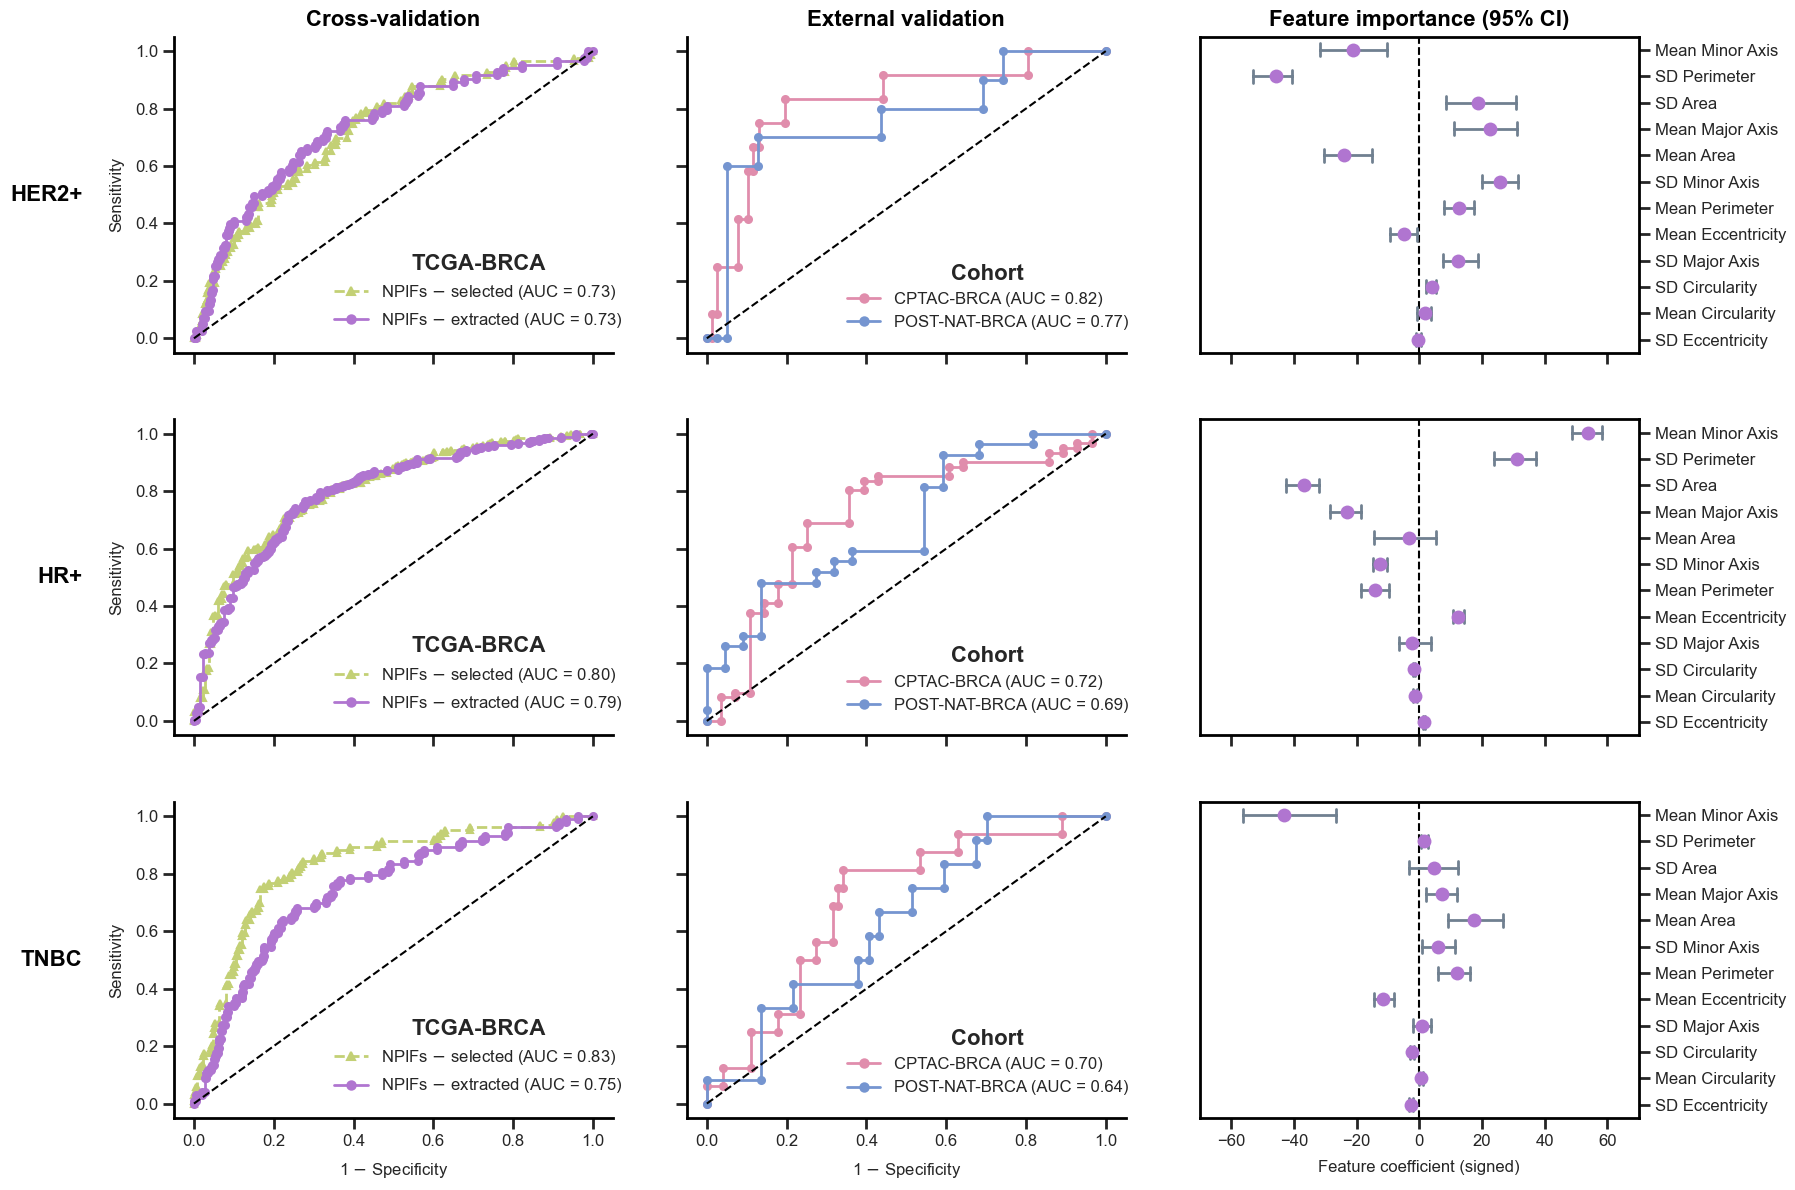

In [19]:
#%% make fig 5.

sns.set_style("ticks")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors       = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
                "#FFC72C", "#708090", "#A9A9A9", "#000000"]

panel_fonts  = {"weight": "bold", "size": 36, "color": "#000000"}
title_fonts  = {"weight": "bold", "size": 16, "color": "#000000"}
label_fonts  = {"weight": "regular", "size": 14, "color": "#000000"}
legend_fonts = {"item" : {"size": 12, "weight": "regular"}, 
                "title": {"size": 16, "weight": "bold"}}

ann_props    = {"color": colors[-1], "family": "sans", "size": 16, 
                "weight": "bold", "alpha": 0.99, "ha": "right", 
                "va": "center", "ma": "center", "rotation": None, 
                "wrap": True}
title_props  = {"wrap": True, "pad": 12, "ha": "center", "va": "center"}
title_props.update(title_fonts)

## make composite figure.
fig5, ax5 = plt.subplots(figsize = (18, 12), nrows = 3, ncols = 3)
ax5       = dict(zip(["A1", "A2", "A3", "B1", "B2", "B3", "C1", "C2", "C3"], 
                     ax5.ravel()))

## cross-validation.
fig_colors5 = [[colors[k] for k in lst] for lst in [[4, 3, -1], [0, 1, -1], [3, 6, -1]]]
fig_xlims5  = ceil(fig_data5C.select_dtypes(include = float).abs().max().max() / 10) * 10
for sb, lbl in zip(subtypes.values(), list("ABC")):
    ## cross-validation.
    ax, color = ax5[f"{lbl}1"], fig_colors5[0]
    ax = make_roc_plot(data = fig_data5A[sb], label = "label", pred = "pred", group = "feature", 
                       colors = color, marker = ["^", "o"], ls = ["--", "-"], ms = 5, 
                       legend_title = "TCGA-BRCA", legend_loc = (0.35, 0.05), ax = ax)
    
    if lbl.startswith("A"):
        ax.set_title("Cross-validation", **title_props);
    if not lbl.startswith("C"):
        ax.set_xlabel(None)
        ax.set_xticklabels([""] * len(ax.get_xticklabels()));
    
    ax.text(x = -0.28, y = 0.50, s = sb, **ann_props);

    ## external validation.
    ax, color = ax5[f"{lbl}2"], fig_colors5[1]
    ax = make_roc_plot(data = fig_data5B[sb], label = "label", pred = "pred", group = "cohort", 
                       colors = color, ms = 5, legend_title = "Cohort", legend_loc = (0.35, 0.05), 
                       ax = ax)
    
    ax.set_ylabel(None)
    ax.set_yticklabels([""] * len(ax.get_yticklabels()));    
    if lbl.startswith("A"):
        ax.set_title("External validation", **title_props);
    if not lbl.startswith("C"):
        ax.set_xlabel(None)
        ax.set_xticklabels([""] * len(ax.get_xticklabels()));

    ## feature importance.
    ax, color = ax5[f"{lbl}3"], fig_colors5[2]
    ax = make_dotplot(data = fig_data5C[sb], x = "coef", y = "feature", ebar = ("ci", 95), 
                      ecap = 0.5, yticks = "right", ms = 10, mew = 0, colors = color, 
                      xlabel = "Feature coefficient (signed)", ax = ax)
    
    ax.set_xlim(-ceil(fig_xlims5 * 1.0), ceil(fig_xlims5 * 1.0));
    if lbl.startswith("A"):
        ax.set_title("Feature importance (95% CI)", **title_props)
    if not lbl.startswith("C"):
        ax.set_xlabel(None)
        ax.set_xticklabels([""] * len(ax.get_xticklabels()));

fig5.tight_layout(w_pad = 2, h_pad = 4)
plt.show()


In [20]:
#%% save fig 5.

svdat = False
if svdat: 
    out_path  = "../../plots/v3/"
    out_file  = "All_NPIFs_validation_feature_importance.pdf"
    out_data  = copy(fig5)
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    
    print("saving performance plots for NPIFs2...");    _dt = time()
    os.makedirs(out_path, exist_ok = True)                            # creates dir if doesn't exist already
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file)
    _dt = time() - _dt;    print(f"done! elapsed time = {ceil(_dt)} sec.")


In [21]:
#%% read data for fig 6.

data_paths = ["../../DataForFigure_V2/Survival_V2/HIFs/", 
              "../../DataForFigure_V2/Survival_V2/nuHIFs/", 
              "../../DataForFigure_V2/Survival_V2/PIFs/", 
              "../../DataForFigure_V2/Survival_V2/HoverNet_NPIFs/"]
data_files = ["All_Subtypes_AllSurvival_Combined_TestSamples_HIFs.csv", 
              "All_Subtypes_AllSurvival_Combined_TestSamples_nuHIFs.csv", 
              "All_Subtypes_AllSurvival_Combined_TestSamples_PIFs.csv", 
              "All_Subtypes_AllSurvival_Combined_TestSamples_HoverNet_NPIFs.csv"]

surv_data_hif   = pd.read_table(data_paths[0] + data_files[0], sep = ",", 
                                header = 0, index_col = 0)
surv_data_nuhif = pd.read_table(data_paths[1] + data_files[1], sep = ",", 
                                header = 0, index_col = 0)
surv_data_pif   = pd.read_table(data_paths[2] + data_files[2], sep = ",", 
                                header = 0, index_col = 0)
surv_data_npif  = pd.read_table(data_paths[3] + data_files[3], sep = ",", 
                                header = 0, index_col = 0)

(surv_data_hif.shape, surv_data_nuhif.shape, surv_data_pif.shape, 
 surv_data_npif.shape)


((556, 8), (556, 8), (556, 8), (556, 8))

In [22]:
#%% prepare data for fig 6.

def normalize(x, q = 0.05):
    """ normalize coxph risk score between 0 and 1 
        while adjusting for outliers (defined by 
        given quantiles) """

    qq = np.quantile(x, q = [q, 1 - q])
    xx = (x - qq[0]) / (qq[1] - qq[0])
    xx[xx < 0] = 0;    xx[xx > 1] = 1
    return xx


features = ["HIFs (m = 607)", "nuHIFs (m = 90)", "PIFs (m = 25)", "NPIFs (m = 12)"]
subtypes = surv_data_pif.groupby(
    by = "Subtype", sort = True).apply(
    lambda df: f"{df.Subtype.iloc[0]}\n(n = {len(df):,})", 
    include_groups = True).to_dict()

## parameters.
surv_out  = "os"
surv_grps = ["Low-risk", "High-risk"]
# surv_grps = ["Low-risk", "Medium-risk", "High-risk"]
# surv_grps = ["Low-risk", "Low-medium-risk", "High-medium-risk", "High-risk"]
norm_qq   = 0.10
grp_th    = 0.50

fig_data6 = {sb: { } for sb in subtypes.values()}
fig_stat6 = {sb: { } for sb in subtypes.values()}
for feat, dat in zip(
    features, [surv_data_hif, surv_data_nuhif, surv_data_pif, surv_data_npif]):
    
    ## each feature set.
    km_data = dat.groupby(
        by = "Subtype", sort = True).apply(
        lambda df: df, include_groups = False)
    km_data["risk_score"] = km_data[f"risk_score_{surv_out}"].pipe(
        lambda x: normalize(x, q = norm_qq))
    # grp_th = km_data.risk_score.mean()
        
    for sb, sb_ in subtypes.items():
        ## each subtype.
        km_data_sb = km_data.loc[sb].copy()
        # km_data_sb["group"] = pd.qcut(
        #     km_data_sb[f"risk_score_{surv_out}"], q = len(surv_grps), labels = surv_grps)        
        # km_data_sb["risk_score"] = km_data_sb[f"risk_score_{surv_out}"].pipe(
        #     lambda x: normalize(x, q = norm_qq))
        # grp_th = km_data_sb.risk_score.mean()
        km_data_sb["group"] = km_data_sb.risk_score.map(
            lambda x: surv_grps[int(x >= grp_th)])
        km_data_sb = km_data_sb.groupby(
            by = "group", observed = False, sort = True).apply(
            lambda df: df, include_groups = False)
        
        ## save data.
        fig_data6[sb_][feat] = {
            grp: KaplanMeierFitter(alpha = 0.05).fit(
                event_observed = km_data_sb.loc[grp, surv_out], 
                durations      = km_data_sb.loc[grp, f"{surv_out}_time"], 
                label          = grp)
            for grp in [surv_grps[0], surv_grps[-1]]}
        
        fig_stat6[sb_][feat] = {
            "Cidx": concordance_index(
                event_observed   = km_data_sb.loc[[surv_grps[0], surv_grps[-1]], surv_out], 
                event_times      = km_data_sb.loc[[surv_grps[0], surv_grps[-1]], f"{surv_out}_time"], 
                predicted_scores = -km_data_sb.loc[[surv_grps[0], surv_grps[-1]], 
                                                   f"risk_score_{surv_out}"]), 
            "pval": logrank_test(
                event_observed_A = km_data_sb.loc[surv_grps[0], surv_out], 
                durations_A      = km_data_sb.loc[surv_grps[0], f"{surv_out}_time"], 
                event_observed_B = km_data_sb.loc[surv_grps[-1], surv_out], 
                durations_B      = km_data_sb.loc[surv_grps[-1], f"{surv_out}_time"]).p_value }


fig_data6 = pd.concat(
    {sb: pd.DataFrame(dat).T for sb, dat in fig_data6.items()}, axis = 1)
fig_stat6 = pd.concat(
    {sb: pd.DataFrame(stat).T for sb, stat in fig_stat6.items()}, axis = 1)

fig_stat6.round(4)


HER2+\n(n = 83)         HR+\n(n = 370)          \
                           Cidx    pval           Cidx    pval   
HIFs (m = 607)           0.4101  0.7406         0.5933  0.1385   
nuHIFs (m = 90)          0.8545  0.0000         0.6489  0.0001   
PIFs (m = 25)            0.8519  0.0186         0.5306  0.3454   
NPIFs (m = 12)           0.8016  0.0414         0.6800  0.0278   

                TNBC\n(n = 103)          
                           Cidx    pval  
HIFs (m = 607)           0.5489  0.8564  
nuHIFs (m = 90)          0.4108  0.5687  
PIFs (m = 25)            0.6638  0.0802  
NPIFs (m = 12)           0.6528  0.9538

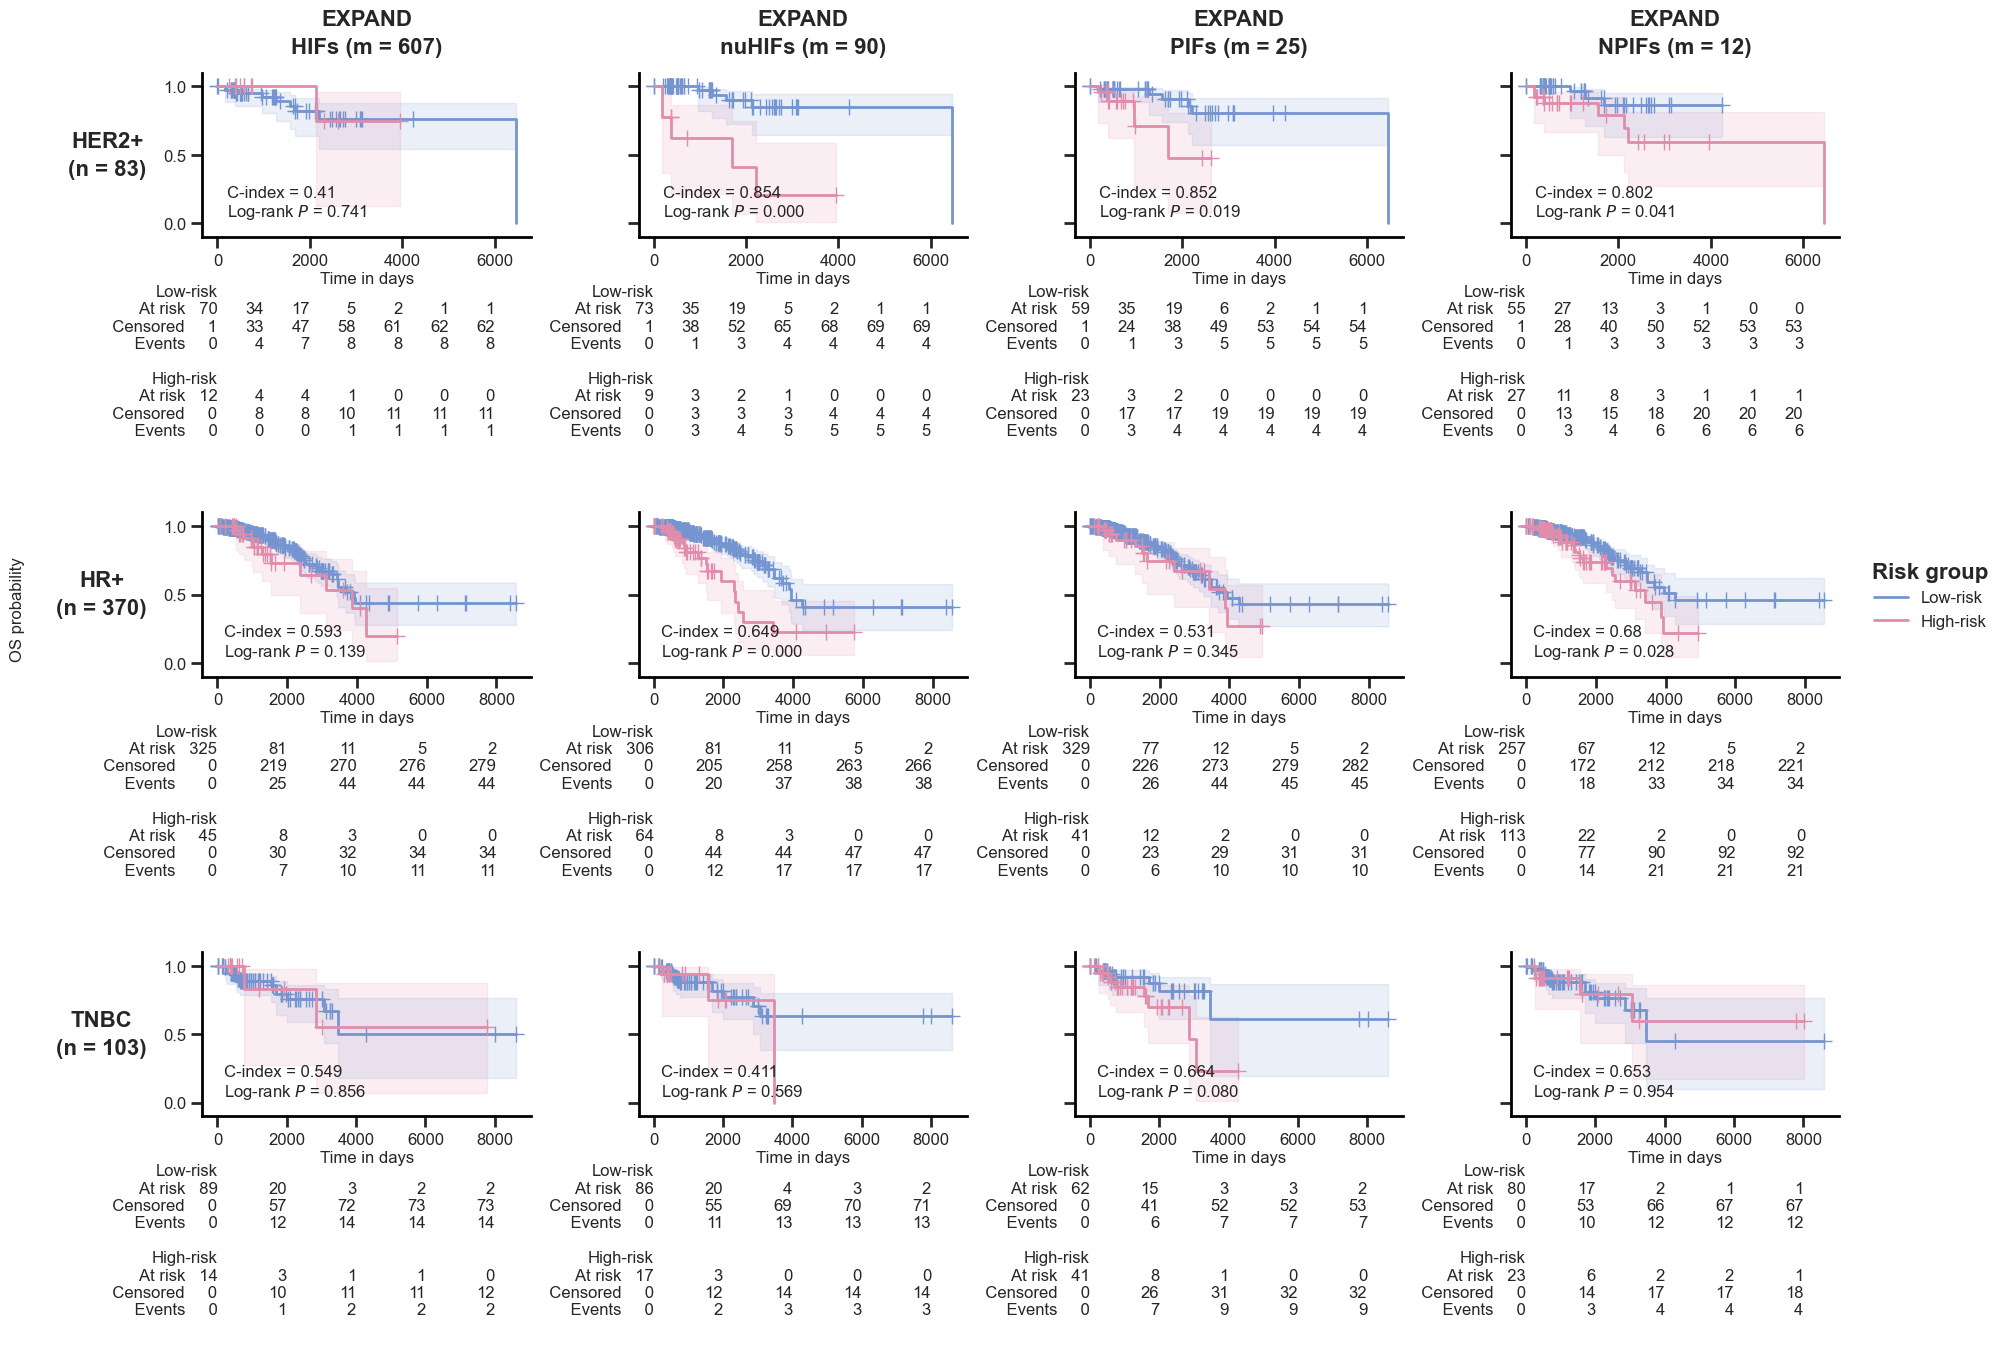

In [23]:
#%% make fig 6.

sns.set_style("ticks")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors     = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
              "#FFC72C", "#708090", "#A9A9A9", "#000000"]
colors     = colors[:2][::-1]

fontdict   = {"label": {"size": 12, "weight": "regular"}, 
              "sbttl": {"size": 14, "weight": "bold"}, 
              "title": {"size": 16, "weight": "bold"}, 
              "super": {"size": 20, "weight": "bold"}, 
              "panel": {"size": 36, "weight": "bold"}}

lineprop   = {"linestyle": "-", "linewidth": 2}

fig6_I, ax6_I = plt.subplots(figsize = (20, 14), nrows = 3, ncols = 4, sharey = True)
for i, (sb, lbl) in enumerate(zip(subtypes.values(), list("ABC"))):
    for j, feat in enumerate(features):
        ax, dat, stat = (ax6_I[i, j], fig_data6.loc[feat, sb], fig_stat6.loc[feat, sb])
        
        ## make KM plot.
        for k, (grp, mdl) in enumerate(dat.items()):
            ax = mdl.plot(show_censors = True, ci_show = True, color = colors[k], 
                          ci_alpha = 0.15, ax = ax, **lineprop)
        ax.text(x = 200, y = 0.05, 
                s = f"C-index = {stat.Cidx:0.3}\nLog-rank $P$ = {stat.pval:0.3f}", 
                **fontdict["label"]);
        add_at_risk_counts(*dat.values, labels = list(dat.keys()), 
                           rows_to_show = None, ax = ax, **fontdict["label"]);
        sns.despine(ax = ax, offset = 0, trim = False);

        ## format ticks & legends.
        ax.set_ylim([-0.1, 1.1]);
        ax.tick_params(axis = "both", labelsize = fontdict["label"]["size"]);        
        ax.set_xlabel("Time in days", labelpad = 2, y = 0.025, **fontdict["label"]);
        if j == 0:
            ax.set_ylabel(sb, y = 0.50, labelpad = 12, rotation = 0, linespacing = 1.5, 
                          ha = "right", va = "center", ma = "center", **fontdict["title"]);

        if i == 0:
            ax.set_title(f"EXPAND\n{feat}", wrap = True, y = 1.1, pad = 8, 
                         linespacing = 1.5, **fontdict["title"]);

        if (i, j) == (1, len(features) - 1):                                      # common legend - middle row, last column
            ax.legend(loc = (1.08, 0.25), title = "Risk group", prop = fontdict["label"], 
                      title_fontproperties = fontdict["title"])
        else:
            ax.legend([ ], [ ]);

    fig6_I.supylabel(f"{surv_out.upper()} probability", x = -0.0005, y = 0.55, 
                     **fontdict["label"]);

fig6_I.tight_layout(h_pad = 2, w_pad = 0)
plt.show()


In [24]:
#%% save fig 6.

svdat = False
if svdat: 
    out_path  = "../../plots/v3/"
    out_file  = f"TCGA_survival_plots_{surv_out}_all_v2.pdf"
    out_data  = copy(fig6_I)
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    
    print("saving survival analysis plots...");    _dt = time()
    os.makedirs(out_path, exist_ok = True)                            # creates dir if doesn't exist already
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file)
    _dt = time() - _dt;    print(f"done! elapsed time = {ceil(_dt)} sec.")


In [27]:
#%% read data for additional figures.

data_paths = ["../../DataForFigure_V2/PathAI_NPIFs/All_Non_Zero_PathAI_NPIFs/", 
              "../../DataForFigure_V2/HoverNet_NPIFs/All_Non_Zero_NPIFs/", 
              "../../DataForFigure_V2/CPTAC_HoverNet_NPIFs/All_Non_Zero_NPIFs/", 
              "../../DataForFigure_V2/POST_NAT_HoverNet_NPIFs/All_Non_Zero_NPIFs/"]
data_files = ["combined_class_predictions_all_subtypes_binary.csv", 
              "External_CPTAC_BRCA_Predictions_All_HoverNet_NPIFs_Filtered_Tiles_Top25Q_Subtypes.csv", 
              "External_POST_NAT_BRCA_Predictions_All_HoverNet_NPIFs_All_Subtypes.csv"]

prob_data_tcga0 = pd.read_table(
    data_paths[0] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_tcga  = pd.read_table(
    data_paths[1] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_cptac = pd.read_table(
    data_paths[2] + data_files[1], sep = ",", header = 0, index_col = 0)
prob_data_pnat  = pd.read_table(
    data_paths[3] + data_files[2], sep = ",", header = 0, index_col = 0)

print((prob_data_tcga0.shape, prob_data_tcga.shape, prob_data_cptac.shape, 
       prob_data_pnat.shape))


((556, 14), (556, 14), (89, 14), (49, 14))


In [64]:
#%% prepare data for additional figures.

subtypes3 = ["HER2_Positive", "HR_Positive", "TNBC_3"]
subtypes3 = {sb: sb.replace("_Positive", "+").split("_")[0] for sb in subtypes3}
subtypes4 = ["TPBC", "HER2+", "HR+", "TNBC_4"]
subtypes4 = {sb: sb.split("_")[0] for sb in subtypes4}

cohorts   = [f"TCGA-BRCA (n = {len(prob_data_tcga):,})", 
             f"CPTAC-BRCA (n = {len(prob_data_cptac):,})", 
             f"POST-NAT-BRCA (n = {len(prob_data_pnat):,})"]

conf_mat3, conf_mat4 = { }, { }
for ds, dat in zip(cohorts, [prob_data_tcga, prob_data_cptac, prob_data_pnat]):
    ## confusion matrix for 3-subtypes.
    y_label = pd.DataFrame({
        sb: dat[f"true_label_{sb_}"] for sb_, sb in subtypes3.items()}).idxmax(
        axis = 1)
    y_pred  = pd.DataFrame({
        sb: dat[f"predicted_probability_{sb_}"] for sb_, sb in subtypes3.items()}).idxmax(
        axis = 1)
    
    conf_mat3[ds] = pd.DataFrame(
        confusion_matrix(y_label, y_pred, labels = list(subtypes3.values()), normalize = "true"), 
        index = pd.MultiIndex.from_tuples(
            [("Ground truth", sb) for sb in subtypes3.values()]), 
        columns = pd.MultiIndex.from_tuples(
            [("Prediction", sb) for sb in subtypes3.values()]))

    ## confusion matrix for 4-subtypes.
    y_label = pd.DataFrame({
        sb: dat[f"true_label_{sb_}"] for sb_, sb in subtypes4.items()}).idxmax(
        axis = 1)
    y_pred  = pd.DataFrame({
        sb: dat[f"predicted_probability_{sb_}"] for sb_, sb in subtypes4.items()}).idxmax(
        axis = 1)
    
    conf_mat4[ds] = pd.DataFrame(
        confusion_matrix(y_label, y_pred, labels = list(subtypes4.values()), normalize = "true"), 
        index = pd.MultiIndex.from_tuples(
            [("Ground truth", sb) for sb in subtypes4.values()]), 
        columns = pd.MultiIndex.from_tuples(
            [("Prediction", sb) for sb in subtypes4.values()]))

conf_mat3, conf_mat4 = pd.concat(conf_mat3, axis = 1), pd.concat(conf_mat4, axis = 1)
conf_mat3.round(3)


TCGA-BRCA (n = 556)               CPTAC-BRCA (n = 89)  \
                            Prediction                        Prediction   
                                 HER2+    HR+   TNBC               HER2+   
Ground truth HER2+               0.434  0.265  0.301               0.417   
             HR+                 0.151  0.722  0.127               0.049   
             TNBC                0.252  0.243  0.505               0.125   

                                 POST-NAT-BRCA (n = 49)                
                                             Prediction                
                      HR+   TNBC                  HER2+    HR+   TNBC  
Ground truth HER2+  0.250  0.333                  0.200  0.400  0.400  
             HR+    0.672  0.279                  0.037  0.630  0.333  
             TNBC   0.312  0.562                  0.000  0.583  0.417

In [65]:
conf_mat4.round(3)


TCGA-BRCA (n = 556)                       \
                            Prediction                        
                                  TPBC  HER2+    HR+   TNBC   
Ground truth TPBC                0.224  0.207  0.328  0.241   
             HER2+               0.120  0.480  0.120  0.280   
             HR+                 0.100  0.069  0.712  0.119   
             TNBC                0.125  0.134  0.268  0.473   

                   CPTAC-BRCA (n = 89)                       \
                            Prediction                        
                                  TPBC  HER2+    HR+   TNBC   
Ground truth TPBC                0.143  0.286  0.571  0.000   
             HER2+               0.000  0.200  0.000  0.800   
             HR+                 0.017  0.017  0.712  0.254   
             TNBC                0.056  0.111  0.333  0.500   

                   POST-NAT-BRCA (n = 49)                      
                               Prediction                      
                                     TPBC  HER2+   HR+   TNBC  
Ground truth TPBC                   0.125  0.125  0.50  0.250  
             HER2+                  0.500  0.000  0.00  0.500  
             HR+                    0.000  0.000  0.63  0.370  
             TNBC                   0.000  0.083  0.50  0.417

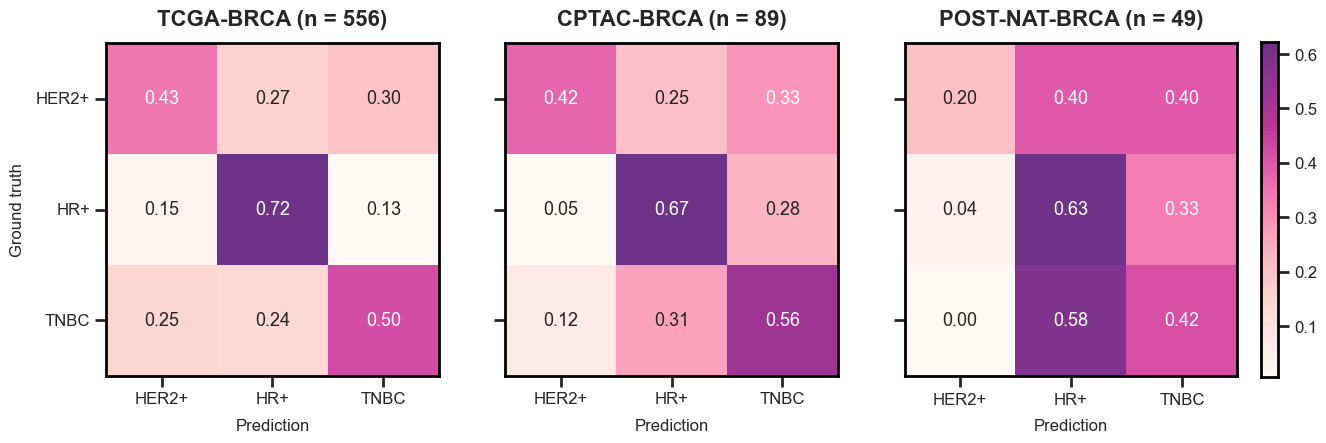

In [62]:
#%% make additional figures.

sns.set_style("ticks")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors       = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
                "#FFC72C", "#708090", "#A9A9A9", "#000000"]

panel_fonts  = {"weight": "bold", "size": 36, "color": "#000000"}
label_fonts  = {"weight": "regular", "size": 14, "color": "#000000"}
legend_fonts = {"item" : {"size": 12, "weight": "regular"}, 
                "title": {"size": 16, "weight": "bold"}}

ann_props    = {"color": colors[-1], "family": "sans", "size": 16, "weight": "bold", 
                "alpha": 0.99, "ha": "center", "va": "center", "ma": "center", 
                "rotation": None, "wrap": True}

## make figure.
fig_x1, ax_x1 = plt.subplots(figsize = (14, 5), nrows = 1, ncols = 3, 
                             width_ratios = [1, 1, 1.43])
ax_x1         = dict(zip(list("ABC"), ax_x1))

for lbl, ds in zip(list("ABC"), cohorts):
    ax  = ax_x1[lbl]
    # dat = conf_mat4[ds].droplevel(level = 0, axis = 0).droplevel(level = 0, axis = 1)
    dat = conf_mat3[ds].droplevel(level = 0, axis = 0).droplevel(level = 0, axis = 1)
    ax  = make_heatmap(data = dat, fmt = "0.2f", square = True, cmap = "RdPu", 
                       bold = False, cbar = (lbl == "C"), cbar_shrink = 0.72, 
                       labels = ["Prediction", "Ground truth"], title = ds, ax = ax)
    if lbl != "A":
        ax.set_ylabel(None)
        ax.set_yticklabels([""] * len(ax.get_yticklabels()));    

fig_x1.tight_layout(h_pad = 2, w_pad = 4)
plt.show()


In [63]:
#%% save additional figures.

svdat = False
if svdat: 
    out_path  = "../../plots/v3/"
    out_file  = f"All_NPIFs_validation_confusion_matrix_subtypes3.pdf"
    # out_file  = f"All_NPIFs_validation_confusion_matrix_subtypes4.pdf"
    out_data  = copy(fig_x1)
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    
    print("saving NPIFs2 validation confusion matrices...");    _dt = time()
    os.makedirs(out_path, exist_ok = True)                            # creates dir if doesn't exist already
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file)
    _dt = time() - _dt;    print(f"done! elapsed time = {ceil(_dt)} sec.")
